[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_8723/1740946056.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'].fillna(50, inplace=True)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2372 - val_loss: 0.0876
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0823 - val_loss: 0.0385
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0534 - val_loss: 0.0442
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0427 - val_loss: 0.0103
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0294 - val_loss: 0.0094
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0250 - val_loss: 0.0138
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0175 - val_loss: 0.0050
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0152 - val_loss: 0.0062
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0126 - val_loss: 0.0050
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039
Test loss: 0.0050125583074986935
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Root Mean Square Erro

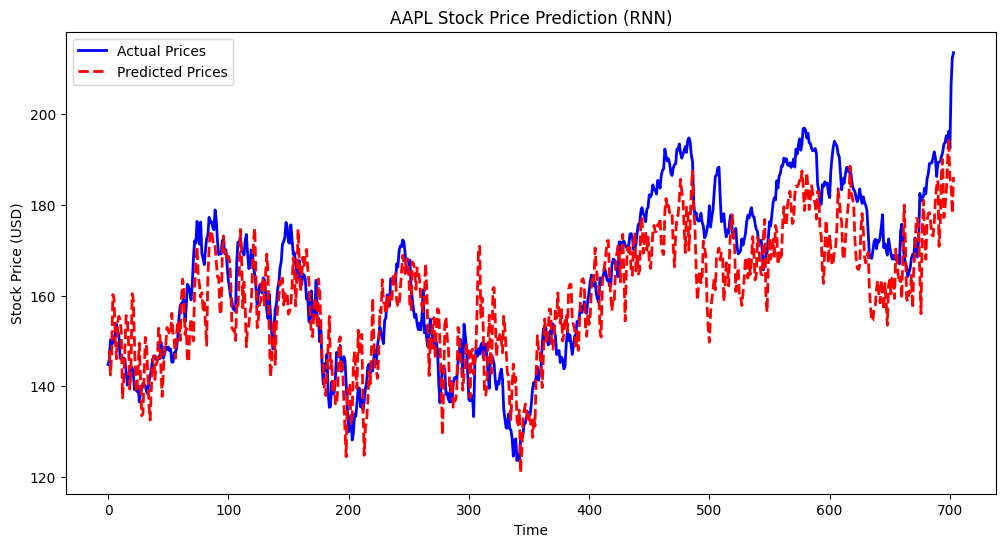

In [9]:
#Importing the required libraries

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

#Error Supression

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Download stock data
def download_stock_data(ticker, start_date='2010-01-01', end_date='2024-06-14'):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Adding technical indicators
def add_technical_indicators(df):
    df['20MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['50MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200MA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'].fillna(50, inplace=True)
    
    df['12EMA'] = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    df['26EMA'] = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()
    
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

# Normalize the data
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', '20MA', '50MA', '200MA', 'RSI', 'MACD']])
    return scaled_data, scaler

# Prepare the time-series data
def create_time_series_data(df, scaled_data, window_size=120):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i])
        y.append(df['Close'].iloc[i])
    return np.array(X), np.array(y)

# Split data into training and testing sets (80% training,20% testing)
def split_data(X, y, test_size=0.2):
    train_size = int(len(X) * (1 - test_size))
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Create RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    #Takes in time series data
    model.add(Input(shape=input_shape))
    #RNN Layers
    model.add(SimpleRNN(units=50, return_sequences=True))
    model.add(SimpleRNN(units=50, return_sequences=False))
    #Dropout to reduce overfitting
    model.add(Dropout(0.2))
    #Optimizer
    model.add(Dense(units=1))
    #Loss Function
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Example usage
ticker = 'AAPL'
df = download_stock_data(ticker)
df = add_technical_indicators(df)

scaled_data, scaler = normalize_data(df)
X, y = create_time_series_data(df, scaled_data)
X_train, X_test, y_train, y_test = split_data(X, y)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

input_shape = (X_train.shape[1], X_train.shape[2])
model = create_rnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_test, y_test_scaled), callbacks=[early_stopping])

loss = model.evaluate(X_test, y_test_scaled)
print(f"Test loss: {loss}")

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

y_test_original = scaler.inverse_transform(y_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Prices", color="blue", linewidth=2)
plt.plot(predictions, label="Predicted Prices", color="red", linestyle="dashed", linewidth=2)
plt.title(f"{ticker} Stock Price Prediction (RNN)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
